In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [11]:
import pickle
import re
import os

import random
import numpy as np
import torch
from random import shuffle
import argparse
import pickle

import collections
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt

from model.CGBERT import *
from model.QACGBERT import *
from model.QACGLONG import *

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_score, recall_score, cohen_kappa_score

from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data.sampler import RandomSampler, SequentialSampler, WeightedRandomSampler
from tqdm import tqdm, trange
from transformers import LongformerTokenizer, LongformerConfig, LongformerForSequenceClassification

from util.optimization import BERTAdam
from util.processor import (Sentihood_NLI_M_Processor,
                            Semeval_NLI_M_Processor,
                            PersentV1_Processor,
                            PersentV2_Processor,
                            PersentV1_Para_Processor,
                            PersentV2_Para_Processor,
                            PersentV1_Longformer_Processor,
                            PersentV2_Longformer_Processor
                           )

from util.tokenization import *

from util.evaluation import *

from util.train_helper import system_setups, getModelOptimizerTokenizer, convert_examples_to_features

from util.processor import *

from model.QACGLONG import *

from util.args_parser import parser


# Process logs

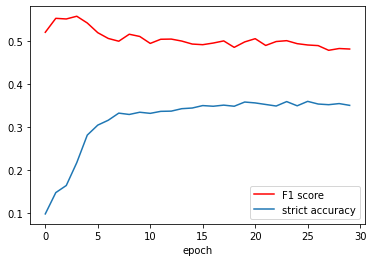

The best otained strict accuracy is 0.3597938144329897
The best otained test accuracy is 0.8470544918998527


In [3]:
def process_log(data):
    data.reset_index(inplace=True)
    data.drop(['s_auc'], axis=1, inplace=True)
    data.columns = ['epoch', 'global_step', 'loss', 't_loss', 't_acc', 'strict_acc', 'f1', 'auc', 's_acc', 's_auc']
    data.drop_duplicates(inplace=True)
    return data

data1 = pd.read_csv('../results/persent_annotated/QACGBERT-7aspects-noNeuMix-30epochs_2e-5/log.txt', sep="\t")
data1 = process_log(data1)

df = data1.groupby(by=['epoch'], as_index=False).max()
df['loss'] = df['loss']  * 8

sns.lineplot(data=df, x="epoch", y="f1", color="red", label="F1 score")
sns.lineplot(data=df, x="epoch", y="strict_acc", label="strict accuracy")
plt.legend()
plt.ylabel("")
plt.show()

print(f'The best otained strict accuracy is {max(df.strict_acc)}')
print(f'The best otained test accuracy is {max(df.t_acc)}')


In [4]:
df[df['strict_acc']==max(df.strict_acc)]

,epoch,global_step,loss,t_loss,t_acc,strict_acc,f1,auc,s_acc,s_auc
25,25,32500,0.030549,1.233507,0.843962,0.359794,0.490714,0.770757,0.717526,0.716904


# Aspect level visualization

## Obtain predictions from best trained model

In [5]:
'''
Same argument format as the ones in Trial Run.ipynb file. 
But remember to swap the init_checkpoint with the best_checkpoint.bin from trained cases.
'''


args_init = ['--task_name', 'persentv2', 
             '--data_dir', '../datasets/persent_annotated/',
             '--output_dir', '../results/persent_annotated/QACGLONG-reproduce22/',
             '--model_type', 'QACGLONG',
             '--do_lower_case',
             '--max_seq_length', '2048',
             '--train_batch_size', '8',
             '--eval_batch_size', '12',
             '--learning_rate', '1e-4',
             '--num_train_epochs', '30',
             '--vocab_file', 'BERT-Google/vocab.txt',
             '--bert_config_file', 'Longformer/config.json',
             '--init_checkpoint', '../results/persent_annotated/QACGLONG-7aspects-noNeuMix-30epochs_2e-5/best_checkpoint.bin', 
             '--seed', '123',
             '--evaluate_interval', '25',
             '--gradient_accumulation_steps', '8']

args = parser.parse_args(args_init)



In [6]:
'''
Set up model, optimizer, tokenizer and data
'''


device, n_gpu, output_log_file= system_setups(args)

processors = {
    "sentihood_NLI_M":Sentihood_NLI_M_Processor,
    "semeval_NLI_M":Semeval_NLI_M_Processor,
    "persentv1":PersentV1_Processor,
    "persentv2":PersentV2_Processor,
    "persentv1_para":PersentV1_Para_Processor,
    "persentv2_para":PersentV2_Para_Processor,
    "persentv1_longformer":PersentV1_Longformer_Processor,
    "persentv2_longformer":PersentV2_Longformer_Processor
}

processor = processors[args.task_name]()
label_list = processor.get_labels()
train_examples = None
num_train_steps = None
train_examples = processor.get_train_examples(args.data_dir)
num_train_steps = int(len(train_examples) / args.train_batch_size * args.num_train_epochs)

model1, optimizer, tokenizer = getModelOptimizerTokenizer(model_type=args.model_type,
                                   vocab_file=args.vocab_file,
                                   config_file=args.bert_config_file,
                                   init_checkpoint=args.init_checkpoint,
                                   label_list=label_list,
                                   do_lower_case=True,
                                   num_train_steps=num_train_steps,
                                   learning_rate=args.learning_rate,
                                   base_learning_rate=args.base_learning_rate,
                                   warmup_proportion=args.warmup_proportion)

model1.to(device)

11/25/2022 22:38:26 - INFO - util.train_helper -   device cuda n_gpu 1 distributed training False


output_log_file= ../results/persent_annotated/QACGLONG-reproduce22/log.txt


11/25/2022 22:38:32 - INFO - util.train_helper -   *** Model Config ***
11/25/2022 22:38:32 - INFO - util.train_helper -   {
  "attention_mode": "longformer",
  "attention_probs_dropout_prob": 0.1,
  "attention_window": [
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512,
    512
  ],
  "bos_token_id": 0,
  "eos_token_id": 2,
  "full_pooler": false,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "ignore_attention_mask": false,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 4098,
  "model_type": "longformer",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "sep_token_id": 2,
  "type_vocab_size": 1,
  "vocab_size": 50265
}

11/25/2022 22:38:32 - INFO - util.train_helper -   model = QACGLONG


init_weight = True


11/25/2022 22:38:34 - INFO - util.train_helper -   retraining with saved model.
11/25/2022 22:38:34 - INFO - util.train_helper -   loading a best checkpoint, not BERT pretrain.


../results/persent_annotated/QACGLONG-7aspects-noNeuMix-30epochs_2e-5/best_checkpoint.bin


QACGBertForSequenceClassification1(
  (bert): ContextBertModel1(
    (embeddings): BERTEmbeddings1(
      (word_embeddings): Embedding(50265, 768)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BERTLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ContextBERTEncoder1(
      (context_layer): ModuleList(
        (0): Linear(in_features=1536, out_features=768, bias=True)
        (1): Linear(in_features=1536, out_features=768, bias=True)
        (2): Linear(in_features=1536, out_features=768, bias=True)
        (3): Linear(in_features=1536, out_features=768, bias=True)
        (4): Linear(in_features=1536, out_features=768, bias=True)
        (5): Linear(in_features=1536, out_features=768, bias=True)
        (6): Linear(in_features=1536, out_features=768, bias=True)
        (7): Linear(in_features=1536, out_features=768, bias=True)
        (8): Linear(in_features=1536, out_fe

In [7]:
# Prepare data

test_examples = processor.get_combo_examples(args.data_dir)
test_features = convert_examples_to_features(
        test_examples, label_list, args.max_seq_length,
        tokenizer, args.max_context_length,
        args.context_standalone, args.task_name)

input_ids = torch.tensor([f.input_ids for f in test_features], dtype=torch.long)
input_mask = torch.tensor([f.input_mask for f in test_features], dtype=torch.long)
segment_ids = torch.tensor([f.segment_ids for f in test_features], dtype=torch.long)
label_ids = torch.tensor([f.label_id for f in test_features], dtype=torch.long)
seq_len = torch.tensor([[f.seq_len] for f in test_features], dtype=torch.long)
context_ids = torch.tensor([f.context_ids for f in test_features], dtype=torch.long)

test_data = TensorDataset(input_ids, input_mask, segment_ids,
                                label_ids, seq_len, context_ids)
test_dataloader = DataLoader(test_data, batch_size=args.eval_batch_size, shuffle=False)

context_ids_eval = torch.clone(context_ids)

100%|██████████| 7385/7385 [00:21<00:00, 340.62it/s]


In [8]:
# Start the process to obtain predictions

test_loss, test_accuracy = 0, 0
nb_test_steps, nb_test_examples = 0, 0
pbar = tqdm(test_dataloader, desc="Iteration")
y_true, y_pred, score = [], [], []
# we don't need gradient in this case.
with torch.no_grad():
        for _, batch in enumerate(pbar):
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            # truncate to save space and computing resource
            input_ids, input_mask, segment_ids, label_ids, seq_lens, \
                context_ids = batch
            max_seq_lens = max(seq_lens)[0]
            input_ids = input_ids[:,:max_seq_lens]
            input_mask = input_mask[:,:max_seq_lens]
            segment_ids = segment_ids[:,:max_seq_lens]

            input_ids = input_ids.to(device)
            input_mask = input_mask.to(device)
            segment_ids = segment_ids.to(device)
            label_ids = label_ids.to(device)
            seq_lens = seq_lens.to(device)
            context_ids = context_ids.to(device)

            if args.task_name == "persentv1_longformer" or args.task_name == "persentv2_longformer":
                tmp_test_loss, logits = \
                    model1(input_ids, input_mask, labels=label_ids, return_dict=False)
            else:
                # intentially with gradient
                tmp_test_loss, logits, _, _, _, _ = \
                    model1(input_ids, segment_ids, input_mask, seq_lens,
                            device=device, labels=label_ids,
                            context_ids=context_ids)

            logits = F.softmax(logits, dim=-1)
            logits = logits.detach().cpu().numpy()
            label_ids = label_ids.to('cpu').numpy()
            outputs = np.argmax(logits, axis=1)
            tmp_test_accuracy=np.sum(outputs == label_ids)

            y_true.append(label_ids)
            y_pred.append(outputs)
            score.append(logits)

            test_loss += tmp_test_loss.mean().item()
            test_accuracy += tmp_test_accuracy

            nb_test_examples += input_ids.size(0)
            nb_test_steps += 1

        test_loss = test_loss / nb_test_steps
        test_accuracy = test_accuracy / nb_test_examples

# we follow previous works in calculating the metrics
y_true = np.concatenate(y_true, axis=0)
y_pred = np.concatenate(y_pred, axis=0)
score = np.concatenate(score, axis=0)

Iteration:   0%|          | 0/616 [00:00<?, ?it/s]11/25/2022 22:39:34 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:39:34 - INFO - model.QACGLONG -   Input ids are automatically padded from 382 to 512 to be a multiple of `config.attention_window`: 512
/home/haoyu/.local/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Iteration:   0%|          | 1/616 [00:00<02:28,  4.13it/s]11/25/2022 22:39:34 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:39:34 - INFO - model.QACGLONG -   Input ids are automatically padded from 285 to 512 to be a multiple of `config.attention_window`: 512
Iteration:   0%|          | 2/616 [00:00<02:12,  4.64it/s]11/25/2022 22:39:35 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/202

11/25/2022 22:39:44 - INFO - model.QACGLONG -   Input ids are automatically padded from 952 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:   5%|▍         | 28/616 [00:10<03:39,  2.68it/s]11/25/2022 22:39:45 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:39:45 - INFO - model.QACGLONG -   Input ids are automatically padded from 229 to 512 to be a multiple of `config.attention_window`: 512
Iteration:   5%|▍         | 29/616 [00:10<03:08,  3.12it/s]11/25/2022 22:39:45 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:39:45 - INFO - model.QACGLONG -   Input ids are automatically padded from 1026 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:   5%|▍         | 30/616 [00:11<03:39,  2.67it/s]11/25/2022 22:39:45 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:39:45 - INFO - model.QACGLONG -   Input ids are automatically padded from 

11/25/2022 22:39:52 - INFO - model.QACGLONG -   Input ids are automatically padded from 492 to 512 to be a multiple of `config.attention_window`: 512
Iteration:   9%|▉         | 55/616 [00:18<02:12,  4.25it/s]11/25/2022 22:39:52 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:39:52 - INFO - model.QACGLONG -   Input ids are automatically padded from 680 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:   9%|▉         | 56/616 [00:18<02:31,  3.71it/s]11/25/2022 22:39:53 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:39:53 - INFO - model.QACGLONG -   Input ids are automatically padded from 437 to 512 to be a multiple of `config.attention_window`: 512
Iteration:   9%|▉         | 57/616 [00:18<02:18,  4.04it/s]11/25/2022 22:39:53 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:39:53 - INFO - model.QACGLONG -   Input ids are automatically padded from 48

11/25/2022 22:40:01 - INFO - model.QACGLONG -   Input ids are automatically padded from 495 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  13%|█▎        | 83/616 [00:26<02:46,  3.20it/s]11/25/2022 22:40:01 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:40:01 - INFO - model.QACGLONG -   Input ids are automatically padded from 578 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  14%|█▎        | 84/616 [00:27<02:51,  3.11it/s]11/25/2022 22:40:01 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:40:01 - INFO - model.QACGLONG -   Input ids are automatically padded from 414 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  14%|█▍        | 85/616 [00:27<02:30,  3.53it/s]11/25/2022 22:40:01 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:40:01 - INFO - model.QACGLONG -   Input ids are automatically padded from 42

11/25/2022 22:40:09 - INFO - model.QACGLONG -   Input ids are automatically padded from 384 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  18%|█▊        | 110/616 [00:35<02:13,  3.80it/s]11/25/2022 22:40:09 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:40:09 - INFO - model.QACGLONG -   Input ids are automatically padded from 721 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  18%|█▊        | 111/616 [00:35<02:25,  3.47it/s]11/25/2022 22:40:10 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:40:10 - INFO - model.QACGLONG -   Input ids are automatically padded from 546 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  19%|█▊        | 114/616 [00:37<04:44,  1.76it/s]11/25/2022 22:40:12 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:40:12 - INFO - model.QACGLONG -   Input ids are automatically padded fro

Iteration:  22%|██▏       | 138/616 [00:45<02:21,  3.39it/s]11/25/2022 22:40:20 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:40:20 - INFO - model.QACGLONG -   Input ids are automatically padded from 516 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  23%|██▎       | 139/616 [00:46<02:27,  3.23it/s]11/25/2022 22:40:20 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:40:20 - INFO - model.QACGLONG -   Input ids are automatically padded from 478 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  23%|██▎       | 140/616 [00:46<02:11,  3.62it/s]11/25/2022 22:40:20 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:40:20 - INFO - model.QACGLONG -   Input ids are automatically padded from 429 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  23%|██▎       | 141/616 [00:46<01:58,  4.00it/s]11/25/2022 22:40:21 - INFO 

Iteration:  27%|██▋       | 165/616 [00:54<02:10,  3.44it/s]11/25/2022 22:40:28 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:40:28 - INFO - model.QACGLONG -   Input ids are automatically padded from 1144 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  27%|██▋       | 166/616 [00:54<02:39,  2.83it/s]11/25/2022 22:40:29 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:40:29 - INFO - model.QACGLONG -   Input ids are automatically padded from 751 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  27%|██▋       | 167/616 [00:55<02:39,  2.81it/s]11/25/2022 22:40:29 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:40:29 - INFO - model.QACGLONG -   Input ids are automatically padded from 354 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  27%|██▋       | 168/616 [00:55<02:18,  3.24it/s]11/25/2022 22:40:30 - INF

Iteration:  31%|███       | 192/616 [01:03<02:15,  3.12it/s]11/25/2022 22:40:38 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:40:38 - INFO - model.QACGLONG -   Input ids are automatically padded from 779 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  31%|███▏      | 193/616 [01:04<02:21,  3.00it/s]11/25/2022 22:40:38 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:40:38 - INFO - model.QACGLONG -   Input ids are automatically padded from 1080 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  31%|███▏      | 194/616 [01:04<02:43,  2.59it/s]11/25/2022 22:40:39 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:40:39 - INFO - model.QACGLONG -   Input ids are automatically padded from 509 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  32%|███▏      | 195/616 [01:04<02:19,  3.01it/s]11/25/2022 22:40:39 - INF

Iteration:  36%|███▌      | 219/616 [01:14<02:51,  2.31it/s]11/25/2022 22:40:48 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:40:48 - INFO - model.QACGLONG -   Input ids are automatically padded from 508 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  36%|███▌      | 220/616 [01:14<02:24,  2.75it/s]11/25/2022 22:40:48 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:40:48 - INFO - model.QACGLONG -   Input ids are automatically padded from 1234 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  36%|███▌      | 221/616 [01:14<02:40,  2.46it/s]11/25/2022 22:40:49 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:40:49 - INFO - model.QACGLONG -   Input ids are automatically padded from 1231 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  36%|███▌      | 222/616 [01:15<02:53,  2.27it/s]11/25/2022 22:40:50 - IN

Iteration:  40%|███▉      | 246/616 [01:22<01:39,  3.71it/s]11/25/2022 22:40:57 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:40:57 - INFO - model.QACGLONG -   Input ids are automatically padded from 1061 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  40%|████      | 247/616 [01:23<02:05,  2.94it/s]11/25/2022 22:40:58 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:40:58 - INFO - model.QACGLONG -   Input ids are automatically padded from 1063 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  40%|████      | 248/616 [01:23<02:24,  2.54it/s]11/25/2022 22:40:58 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:40:58 - INFO - model.QACGLONG -   Input ids are automatically padded from 405 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  40%|████      | 249/616 [01:24<02:03,  2.97it/s]11/25/2022 22:40:58 - IN

Iteration:  45%|████▍     | 275/616 [01:34<02:07,  2.68it/s]11/25/2022 22:41:09 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:41:09 - INFO - model.QACGLONG -   Input ids are automatically padded from 327 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  45%|████▍     | 276/616 [01:35<01:49,  3.10it/s]11/25/2022 22:41:09 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:41:09 - INFO - model.QACGLONG -   Input ids are automatically padded from 620 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  45%|████▍     | 277/616 [01:35<01:54,  2.97it/s]11/25/2022 22:41:10 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:41:10 - INFO - model.QACGLONG -   Input ids are automatically padded from 753 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  45%|████▌     | 278/616 [01:35<01:55,  2.92it/s]11/25/2022 22:41:10 - INFO

Iteration:  49%|████▉     | 303/616 [01:44<01:56,  2.68it/s]11/25/2022 22:41:19 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:41:19 - INFO - model.QACGLONG -   Input ids are automatically padded from 886 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  49%|████▉     | 304/616 [01:44<01:54,  2.71it/s]11/25/2022 22:41:19 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:41:19 - INFO - model.QACGLONG -   Input ids are automatically padded from 1008 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  50%|████▉     | 307/616 [01:46<03:03,  1.68it/s]11/25/2022 22:41:21 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:41:21 - INFO - model.QACGLONG -   Input ids are automatically padded from 783 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  50%|█████     | 308/616 [01:47<02:43,  1.88it/s]11/25/2022 22:41:21 - IN

Iteration:  54%|█████▎    | 331/616 [01:53<01:49,  2.60it/s]11/25/2022 22:41:28 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:41:28 - INFO - model.QACGLONG -   Input ids are automatically padded from 1040 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  54%|█████▍    | 332/616 [01:53<02:00,  2.35it/s]11/25/2022 22:41:28 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:41:28 - INFO - model.QACGLONG -   Input ids are automatically padded from 538 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  54%|█████▍    | 333/616 [01:54<01:55,  2.46it/s]11/25/2022 22:41:28 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:41:28 - INFO - model.QACGLONG -   Input ids are automatically padded from 1341 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  54%|█████▍    | 334/616 [01:54<02:03,  2.29it/s]11/25/2022 22:41:29 - I

Iteration:  58%|█████▊    | 358/616 [02:02<01:31,  2.81it/s]11/25/2022 22:41:37 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:41:37 - INFO - model.QACGLONG -   Input ids are automatically padded from 793 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  58%|█████▊    | 359/616 [02:03<01:31,  2.82it/s]11/25/2022 22:41:38 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:41:38 - INFO - model.QACGLONG -   Input ids are automatically padded from 609 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  58%|█████▊    | 360/616 [02:03<01:30,  2.83it/s]11/25/2022 22:41:38 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:41:38 - INFO - model.QACGLONG -   Input ids are automatically padded from 439 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  59%|█████▊    | 361/616 [02:03<01:18,  3.25it/s]11/25/2022 22:41:38 - INFO

Iteration:  62%|██████▎   | 385/616 [02:12<01:03,  3.66it/s]11/25/2022 22:41:46 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:41:46 - INFO - model.QACGLONG -   Input ids are automatically padded from 410 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  63%|██████▎   | 386/616 [02:12<00:56,  4.04it/s]11/25/2022 22:41:46 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:41:46 - INFO - model.QACGLONG -   Input ids are automatically padded from 358 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  63%|██████▎   | 387/616 [02:12<00:52,  4.35it/s]11/25/2022 22:41:47 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:41:47 - INFO - model.QACGLONG -   Input ids are automatically padded from 291 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  63%|██████▎   | 388/616 [02:12<00:49,  4.61it/s]11/25/2022 22:41:47 - INFO -

Iteration:  67%|██████▋   | 412/616 [02:19<01:08,  2.96it/s]11/25/2022 22:41:53 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:41:53 - INFO - model.QACGLONG -   Input ids are automatically padded from 932 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  67%|██████▋   | 413/616 [02:19<01:09,  2.92it/s]11/25/2022 22:41:54 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:41:54 - INFO - model.QACGLONG -   Input ids are automatically padded from 585 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  67%|██████▋   | 414/616 [02:20<01:09,  2.89it/s]11/25/2022 22:41:54 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:41:54 - INFO - model.QACGLONG -   Input ids are automatically padded from 785 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  67%|██████▋   | 415/616 [02:20<01:09,  2.87it/s]11/25/2022 22:41:55 - INF

Iteration:  71%|███████▏  | 439/616 [02:27<00:56,  3.16it/s]11/25/2022 22:42:02 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:42:02 - INFO - model.QACGLONG -   Input ids are automatically padded from 739 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  71%|███████▏  | 440/616 [02:27<00:57,  3.05it/s]11/25/2022 22:42:02 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:42:02 - INFO - model.QACGLONG -   Input ids are automatically padded from 156 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  72%|███████▏  | 441/616 [02:28<00:50,  3.47it/s]11/25/2022 22:42:02 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:42:02 - INFO - model.QACGLONG -   Input ids are automatically padded from 505 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  72%|███████▏  | 442/616 [02:28<00:44,  3.87it/s]11/25/2022 22:42:02 - INFO 

Iteration:  76%|███████▌  | 466/616 [02:36<00:58,  2.58it/s]11/25/2022 22:42:11 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:42:11 - INFO - model.QACGLONG -   Input ids are automatically padded from 724 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  76%|███████▌  | 467/616 [02:37<00:56,  2.65it/s]11/25/2022 22:42:11 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:42:11 - INFO - model.QACGLONG -   Input ids are automatically padded from 1042 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  76%|███████▌  | 468/616 [02:37<01:02,  2.37it/s]11/25/2022 22:42:12 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:42:12 - INFO - model.QACGLONG -   Input ids are automatically padded from 1044 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  76%|███████▌  | 469/616 [02:38<01:06,  2.22it/s]11/25/2022 22:42:12 - I

Iteration:  80%|████████  | 493/616 [02:46<00:34,  3.56it/s]11/25/2022 22:42:20 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:42:20 - INFO - model.QACGLONG -   Input ids are automatically padded from 323 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  80%|████████  | 494/616 [02:46<00:30,  3.95it/s]11/25/2022 22:42:20 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:42:20 - INFO - model.QACGLONG -   Input ids are automatically padded from 268 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  80%|████████  | 495/616 [02:46<00:28,  4.26it/s]11/25/2022 22:42:21 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:42:21 - INFO - model.QACGLONG -   Input ids are automatically padded from 927 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  81%|████████  | 496/616 [02:46<00:32,  3.74it/s]11/25/2022 22:42:21 - INFO 

Iteration:  84%|████████▍ | 520/616 [02:55<00:33,  2.91it/s]11/25/2022 22:42:30 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:42:30 - INFO - model.QACGLONG -   Input ids are automatically padded from 351 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  85%|████████▍ | 521/616 [02:55<00:28,  3.32it/s]11/25/2022 22:42:30 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:42:30 - INFO - model.QACGLONG -   Input ids are automatically padded from 292 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  85%|████████▍ | 522/616 [02:55<00:25,  3.73it/s]11/25/2022 22:42:30 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:42:30 - INFO - model.QACGLONG -   Input ids are automatically padded from 810 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  85%|████████▍ | 523/616 [02:56<00:27,  3.44it/s]11/25/2022 22:42:30 - INFO 

Iteration:  89%|████████▉ | 547/616 [03:03<00:23,  2.95it/s]11/25/2022 22:42:38 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:42:38 - INFO - model.QACGLONG -   Input ids are automatically padded from 1310 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  89%|████████▉ | 548/616 [03:04<00:26,  2.55it/s]11/25/2022 22:42:38 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:42:38 - INFO - model.QACGLONG -   Input ids are automatically padded from 1086 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  89%|████████▉ | 549/616 [03:04<00:28,  2.32it/s]11/25/2022 22:42:39 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:42:39 - INFO - model.QACGLONG -   Input ids are automatically padded from 296 to 512 to be a multiple of `config.attention_window`: 512
Iteration:  89%|████████▉ | 550/616 [03:04<00:23,  2.76it/s]11/25/2022 22:42:39 - IN

11/25/2022 22:42:47 - INFO - model.QACGLONG -   Input ids are automatically padded from 1044 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  93%|█████████▎| 575/616 [03:13<00:15,  2.67it/s]11/25/2022 22:42:48 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:42:48 - INFO - model.QACGLONG -   Input ids are automatically padded from 1189 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  94%|█████████▎| 576/616 [03:14<00:16,  2.39it/s]11/25/2022 22:42:48 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:42:48 - INFO - model.QACGLONG -   Input ids are automatically padded from 1061 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  94%|█████████▎| 577/616 [03:14<00:17,  2.23it/s]11/25/2022 22:42:49 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:42:49 - INFO - model.QACGLONG -   Input ids are automatically padded

11/25/2022 22:42:56 - INFO - model.QACGLONG -   Input ids are automatically padded from 1190 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  98%|█████████▊| 602/616 [03:22<00:05,  2.75it/s]11/25/2022 22:42:57 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:42:57 - INFO - model.QACGLONG -   Input ids are automatically padded from 887 to 1024 to be a multiple of `config.attention_window`: 512
Iteration:  98%|█████████▊| 603/616 [03:23<00:04,  2.74it/s]11/25/2022 22:42:57 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:42:57 - INFO - model.QACGLONG -   Input ids are automatically padded from 1131 to 1536 to be a multiple of `config.attention_window`: 512
Iteration:  98%|█████████▊| 604/616 [03:23<00:04,  2.45it/s]11/25/2022 22:42:58 - INFO - model.QACGLONG -   Initializing global attention on CLS token...
11/25/2022 22:42:58 - INFO - model.QACGLONG -   Input ids are automatically padded 

## Results of QACG-BERT or QACG-LONG

In [12]:
warnings.filterwarnings("ignore")

aspects_true4 = [[] for i in range(4)]
aspects_pred4 = [[] for i in range(4)]

aspects_true7 = [[] for i in range(7)]
aspects_pred7 = [[] for i in range(7)]

total, accuracy, precision, recall, f1 = [], [], [], [], []
for i in range(len(y_true)):
    
# Comment 4 aspects commands (the next 2 commands) if the case is 7-aspect dataset

#     aspects_true4[context_ids_eval[i][0]].append(y_true[i])
#     aspects_pred4[context_ids_eval[i][0]].append(y_pred[i])

# Comment 7 aspects commands (the next 2 commands) if the case is 4-aspect dataset
    aspects_true7[context_ids_eval[i][0]].append(y_true[i])
    aspects_pred7[context_ids_eval[i][0]].append(y_pred[i])
    
    
# Comment the next for loop if the case is 7-aspect dataset
# for j in range(4):
#     total.append(len(aspects_true4[j]))
#     accuracy.append(accuracy_score(aspects_true4[j], aspects_pred4[j]))
#     precision.append(precision_score(aspects_true4[j], aspects_pred4[j], average='macro'))
#     recall.append(recall_score(aspects_true4[j], aspects_pred4[j], average='macro'))
#     f1.append(f1_score(aspects_true4[j], aspects_pred4[j], average='macro'))

# Comment the next for loop if the case is 4-aspect dataset
for j in range(7):
    total.append(len(aspects_true7[j]))
    accuracy.append(accuracy_score(aspects_true7[j], aspects_pred7[j]))
    precision.append(precision_score(aspects_true7[j], aspects_pred7[j], average='macro'))
    recall.append(recall_score(aspects_true7[j], aspects_pred7[j], average='macro'))
    f1.append(f1_score(aspects_true7[j], aspects_pred7[j], average='macro'))

group7V1 = ['politics', 'recreation', 'computer', 'religion', 'science', 'sale', 'general']
group4V1 = ['politics', 'general', 'recreation', 'science']
group7V2 = ['work occupation', 'crime justice system', 'digital online', 'social inequality human rights', 'economic issues', 'other not a social issue', 'public health']
group4V2 = ['work occupation', 'crime justice system', 'digital online', 'social inequality human rights']

# Remember to use correct aspect group for corresponding case
df = pd.DataFrame({'group': group7V2, 'total': total, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})
df.sort_values(by=['total'], inplace=True)
df.reset_index(inplace=True)
df.drop(['index'], axis=1, inplace=True)
df

,group,total,accuracy,precision,recall,f1
0,work occupation,1055,0.721327,0.515517,0.531594,0.521436
1,crime justice system,1055,0.855924,0.583982,0.584745,0.569353
2,digital online,1055,0.759242,0.412126,0.428594,0.418758
3,social inequality human rights,1055,0.831280,0.428079,0.409813,0.406417
4,economic issues,1055,0.942180,0.651518,0.537008,0.570574
5,other not a social issue,1055,0.936493,0.498634,0.408708,0.433634
6,public health,1055,0.951659,0.668927,0.662688,0.663789


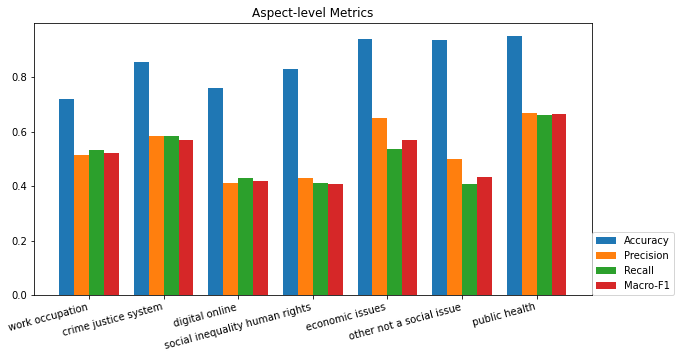

In [13]:
fig, ax  = plt.subplots(1,1, figsize = (10,5))

# Remember to set x ticks for different number of aspects
x = np.arange(7)
# x = np.arange(4)


width = 0.2

ax.bar(x-3*width/2, df['accuracy'], width, label='Accuracy')
ax.bar(x-width/2, df['precision'], width, label='Precision')
ax.bar(x+width/2, df['recall'], width, label='Recall')
ax.bar(x+3*width/2, df['f1'], width, label='Macro-F1')
ax.set_title('Aspect-level Metrics')

ax.set_xticks(x)
plt.setp(ax.get_xticklabels(), ha="right", rotation=15)
ax.set_xticklabels(df['group'].astype(str).values)
ax.legend(loc=(1,0))
plt.show()

## Results of Longformer

In [ ]:
warnings.filterwarnings("ignore")

aspect7_true = [[], [], [], [], [], [], []]
aspect7_pred = [[], [], [], [], [], [], []]

aspect4_true = [[], [], [], []]
aspect4_pred = [[], [], [], []]

total, accuracy, precision, recall, f1 = [], [], [], [], []

# Comment the next for loop if it is PerSent V2 dataset
# for i in range(len(y_true)//4):
#     if y_true[i*4] != 1:
# # Comment 4 aspects commands (the next 2 commands) if the case is 7-aspect dataset

# #         aspect4_true[i%4].append(y_true[i*4:i*4+4])
# #         aspect4_pred[i%4].append(y_pred[i*4:i*4+4])

# # Comment 7 aspects commands (the next 2 commands) if the case is 4-aspect dataset

#         aspect7_true[i%7].append(y_true[i*4:i*4+4])
#         aspect7_pred[i%7].append(y_pred[i*4:i*4+4])


# Comment the next for loop if it is PerSent V1 dataset
for i in range(len(y_true)//3):
    if y_true[i*3] != 1:
        
# Comment 4 aspects commands (the next 2 commands) if the case is 7-aspect dataset

#         aspect4_true[i%4].append(y_true[i*3:i*3+3])
#         aspect4_pred[i%4].append(y_pred[i*3:i*3+3])

# Comment 7 aspects commands (the next 2 commands) if the case is 4-aspect dataset
        aspect7_true[i%7].append(y_true[i*3:i*3+3])
        aspect7_pred[i%7].append(y_pred[i*3:i*3+3])
        
# Comment the next for loop if the case is 7-aspect dataset
# for j in range(4):
#     total.append(len(aspect4_true[j]))
#     accuracy.append(accuracy_score(aspect4_true[j], aspect4_pred[j]))
#     precision.append(precision_score(aspect4_true[j], aspect4_pred[j], average='macro'))
#     recall.append(recall_score(aspect4_true[j], aspect4_pred[j], average='macro'))
#     f1.append(f1_score(aspect4_true[j], aspect4_pred[j], average='macro'))

# Comment the next for loop if the case is 4-aspect dataset
for j in range(7):
    total.append(len(aspect7_true[j]))
    accuracy.append(accuracy_score(aspect7_true[j], aspect7_pred[j]))
    precision.append(precision_score(aspect7_true[j], aspect7_pred[j], average='macro'))
    recall.append(recall_score(aspect7_true[j], aspect7_pred[j], average='macro'))
    f1.append(f1_score(aspect7_true[j], aspect7_pred[j], average='macro'))

group7V1 = ['politics', 'recreation', 'computer', 'religion', 'science', 'sale', 'general']
group4V1 = ['politics', 'general', 'recreation', 'science']
group7V2 = ['work occupation', 'crime justice system', 'digital online', 'social inequality human rights', 'economic issues', 'other not a social issue', 'public health']
group4V2 = ['work occupation', 'crime justice system', 'digital online', 'social inequality human rights']

# Remember to use correct aspect group for corresponding case
df = pd.DataFrame({'group': group7V2, 'total': total, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1})

df.sort_values(by=['total'], inplace=True)
df.reset_index(inplace=True)
df.drop(['index'], axis=1, inplace=True)
df

In [ ]:
fig, ax  = plt.subplots(1,1, figsize = (8,4))

# Remember to set x ticks for different number of aspects
x = np.arange(7)
# x = np.arange(4)

width = 0.2

ax.bar(x-3*width/2, df['accuracy'], width, label='Accuracy')
ax.bar(x-width/2, df['precision'], width, label='Precision')
ax.bar(x+width/2, df['recall'], width, label='Recall')
ax.bar(x+3*width/2, df['f1'], width, label='Macro-F1')
ax.set_title('Aspect-level Metrics')

ax.set_xticks(x)
plt.setp(ax.get_xticklabels(), ha="right", rotation=15)
ax.set_xticklabels(df['group'].astype(str).values)
ax.legend(loc=(1,0))
plt.show()